In [1]:
#hide
! pip install -Uqq fastbook kaggle waterfallcharts treeinterpreter dtreeviz
import fastbook
fastbook.setup_book()

/usr/lib/python3/dist-packages/secretstorage/dhcrypto.py:15: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/usr/lib/python3/dist-packages/secretstorage/util.py:19: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes


In [2]:
fastbook.setup_book()

In [3]:
#hide
from fastbook import *
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG

pd.options.display.max_rows = 20
pd.options.display.max_columns = 8

In [4]:
# create destination path for data
path = URLs.path('bluebook')
path

Path('/home/mchristos/.fastai/archive/bluebook')

In [5]:
# download from Kaggle 
from kaggle import api
comp = 'bluebook-for-bulldozers'
cred_path = Path('~/.kaggle/kaggle.json').expanduser()

if not path.exists():
    path.mkdir(parents=true)
    api.competition_download_cli(comp, path=path)
    shutil.unpack_archive(str(path/f'{comp}.zip'), str(path))

path.ls(file_type='text')

(#7) [Path('/home/mchristos/.fastai/archive/bluebook/TrainAndValid.csv'),Path('/home/mchristos/.fastai/archive/bluebook/Valid.csv'),Path('/home/mchristos/.fastai/archive/bluebook/random_forest_benchmark_test.csv'),Path('/home/mchristos/.fastai/archive/bluebook/Test.csv'),Path('/home/mchristos/.fastai/archive/bluebook/median_benchmark.csv'),Path('/home/mchristos/.fastai/archive/bluebook/ValidSolution.csv'),Path('/home/mchristos/.fastai/archive/bluebook/Machine_Appendix.csv')]

In [6]:
df = pd.read_csv(path/'TrainAndValid.csv', low_memory=False)
df.head()

,SalesID,SalePrice,MachineID,ModelID,...,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000.0,999089,3157,...,NaN,NaN,Standard,Conventional
1,1139248,57000.0,117657,77,...,NaN,NaN,Standard,Conventional
2,1139249,10000.0,434808,7009,...,NaN,NaN,NaN,NaN
3,1139251,38500.0,1026470,332,...,NaN,NaN,NaN,NaN
4,1139253,11000.0,1057373,17311,...,NaN,NaN,NaN,NaN


In [7]:
df.ProductSize.unique()

array([nan, 'Medium', 'Small', 'Large / Medium', 'Mini', 'Large', 'Compact'], dtype=object)

In [8]:
# ordering the size categorical variable from small to large 
sizes = 'Compact', 'Mini', 'Small', 'Medium', 'Large / Medium', 'Large'
df['ProductSize'] = df['ProductSize'].astype('category')
df['ProductSize'].cat.set_categories(sizes, ordered=True, inplace=True)

In [9]:
dep_var = 'SalePrice'
df[dep_var] = np.log(df[dep_var])
df[dep_var]

0         11.097410
1         10.950807
2          9.210340
3         10.558414
4          9.305651
            ...    
412693     9.210340
412694     9.259131
412695     9.433484
412696     9.210340
412697     9.472705
Name: SalePrice, Length: 412698, dtype: float64

Use fastai's add_datepart to create useful features out of the "saledate" column, e.g. day of week

In [10]:
df['saledate']

0         11/16/2006 0:00
1          3/26/2004 0:00
2          2/26/2004 0:00
3          5/19/2011 0:00
4          7/23/2009 0:00
               ...       
412693      3/7/2012 0:00
412694     1/28/2012 0:00
412695     1/28/2012 0:00
412696      3/7/2012 0:00
412697     1/28/2012 0:00
Name: saledate, Length: 412698, dtype: object

In [11]:
df = add_datepart(df, "saledate")

In [12]:
" ".join(c for c in df.columns if c.startswith("sale"))

'saleYear saleMonth saleWeek saleDay saleDayofweek saleDayofyear saleIs_month_end saleIs_month_start saleIs_quarter_end saleIs_quarter_start saleIs_year_end saleIs_year_start saleElapsed'

In [13]:
df_test = pd.read_csv(path/"Test.csv", low_memory=False)
df_test = add_datepart(df_test, "saledate")

In [14]:
df_test.saleMonth.value_counts()

6     3041
5     2493
9     2177
8     1560
10    1441
11     882
7      863
Name: saleMonth, dtype: int64

In [15]:
train_condition = (df.saleYear < 2011) | (df.saleMonth < 10)
train_idx = np.where(train_condition)[0]
valid_idx = np.where(~train_condition)[0]
len(train_idx), len(valid_idx)

(404710, 7988)

In [16]:
splits = (list(train_idx), list(valid_idx))
procs = [Categorify, FillMissing]
cont,cat = cont_cat_split(df, 1, dep_var=dep_var)
print("continuous vars:", cont[:3], "categorical vars: ", cat[:3])
# to = tabular object 
to = TabularPandas(df, procs, cat, cont, y_names=dep_var, splits=splits)
len(to.train), len(to.valid)

continuous vars: ['SalesID', 'MachineID', 'ModelID'] categorical vars:  ['UsageBand', 'fiModelDesc', 'fiBaseModel']


(404710, 7988)

In [17]:
to.items.head(3)

,SalesID,SalePrice,MachineID,ModelID,...,saleIs_year_start,saleElapsed,auctioneerID_na,MachineHoursCurrentMeter_na
0,1139246,11.097410,999089,3157,...,1,1.163635e+09,1,1
1,1139248,10.950807,117657,77,...,1,1.080259e+09,1,1
2,1139249,9.210340,434808,7009,...,1,1.077754e+09,1,1


In [18]:
Path.BASE_PATH = path

In [19]:
save_pickle(path/'to.pkl',to)

In [20]:
to = load_pickle(path/'to.pkl')

In [21]:
to.show(3)

,UsageBand,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,auctioneerID_na,MachineHoursCurrentMeter_na,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,saleYear,saleMonth,saleWeek,saleDay,saleDayofweek,saleDayofyear,saleElapsed,SalePrice
0,Low,521D,521,D,#na#,#na#,#na#,Wheel Loader - 110.0 to 120.0 Horsepower,Alabama,WL,Wheel Loader,#na#,EROPS w AC,None or Unspecified,#na#,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,2 Valve,#na#,#na#,#na#,#na#,None or Unspecified,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Standard,Conventional,False,False,False,False,False,False,False,False,1139246,999089,3157,121,3.0,2004,68.0,2006,11,46,16,3,320,1.163635e+09,11.097410
1,Low,950FII,950,F,II,#na#,Medium,Wheel Loader - 150.0 to 175.0 Horsepower,North Carolina,WL,Wheel Loader,#na#,EROPS w AC,None or Unspecified,#na#,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,2 Valve,#na#,#na#,#na#,#na#,23.5,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Standard,Conventional,False,False,False,False,False,False,False,False,1139248,117657,77,121,3.0,1996,4640.0,2004,3,13,26,4,86,1.080259e+09,10.950807
2,High,226,226,#na#,#na#,#na#,#na#,Skid Steer Loader - 1351.0 to 1601.0 Lb Operating Capacity,New York,SSL,Skid Steer Loaders,#na#,OROPS,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Auxiliary,#na#,#na#,#na#,#na#,#na#,None or Unspecified,None or Unspecified,None or Unspecified,Standard,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,False,False,False,False,False,False,False,False,1139249,434808,7009,121,3.0,2001,2838.0,2004,2,9,26,3,57,1.077754e+09,9.210340


In [22]:
# in reality categorical variables are stored as integers 
to.items['UsageBand'].head()

0    2
1    2
2    1
3    1
4    3
Name: UsageBand, dtype: int8

In [23]:
xs, y = to.train.xs, to.train.y
valid_xs, valid_y = to.valid.xs, to.valid.y
xs.shape, y.shape, valid_xs.shape, valid_y.shape

((404710, 66), (404710,), (7988, 66), (7988,))

In [24]:
xs

,UsageBand,fiModelDesc,fiBaseModel,fiSecondaryDesc,...,saleDay,saleDayofweek,saleDayofyear,saleElapsed
0,2,963,298,43,...,16,3,320,1.163635e+09
1,2,1745,529,57,...,26,4,86,1.080259e+09
2,1,336,111,0,...,26,3,57,1.077754e+09
3,1,3716,1381,0,...,19,3,139,1.305763e+09
4,3,4261,1538,0,...,23,3,204,1.248307e+09
...,...,...,...,...,...,...,...,...,...
412693,0,490,160,108,...,7,2,67,1.331078e+09
412694,0,491,160,108,...,28,5,28,1.327709e+09
412695,0,490,160,108,...,28,5,28,1.327709e+09
412696,0,490,160,108,...,7,2,67,1.331078e+09


In [25]:
# try train a decision tree with only 4 leaf nodes 
m = DecisionTreeRegressor(max_leaf_nodes=4)
m.fit(xs.values, y.values)

DecisionTreeRegressor(max_leaf_nodes=4)

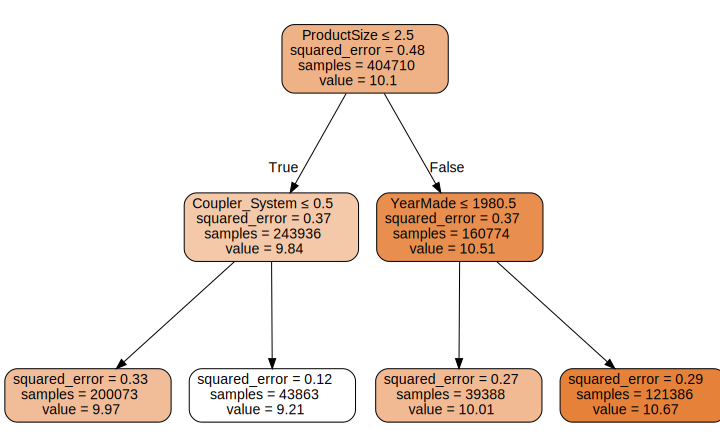

In [26]:
draw_tree(m, xs, size=10, leaves_parallel=True, precision=2)

<AxesSubplot:ylabel='Frequency'>

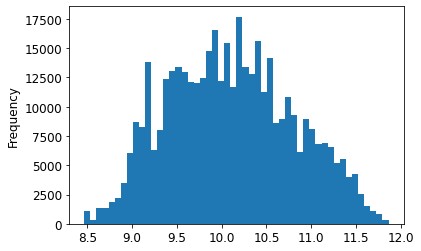

In [27]:
df["SalePrice"].plot.hist(bins=50)

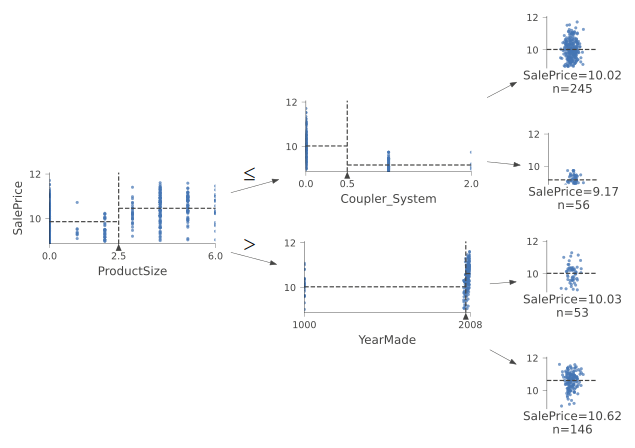

In [28]:
# sample 500 labels 
sample_idx = np.random.permutation(len(y))[:500]
dtreeviz(m, xs.iloc[sample_idx], y.iloc[sample_idx], xs.columns, dep_var,scale=1.6, label_fontsize=10, orientation='LR', fontname="DejaVu Sans")
# plt.show()

In [29]:
# many seem to have a yearMade of 1000 which doesn't make sense. We change it to 1950 so that we can visualize this a little better 
xs.loc[xs['YearMade']<1990,'YearMade'] = 1950
valid_xs.loc[valid_xs['YearMade']<1990,'YearMade'] = 1950

/home/mchristos/.local/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


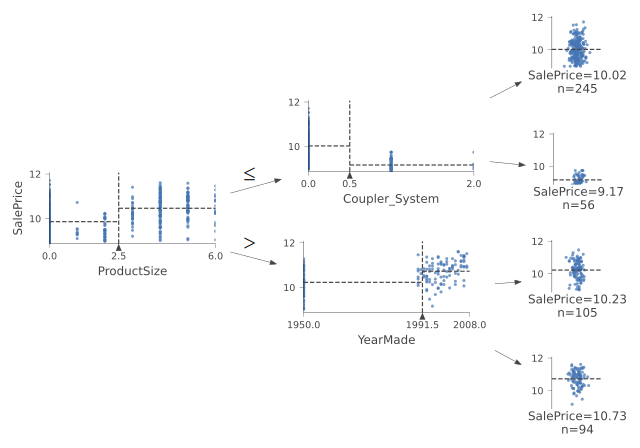

In [30]:
m = DecisionTreeRegressor(max_leaf_nodes=4).fit(xs,y)
dtreeviz(m, xs.iloc[sample_idx], y.iloc[sample_idx], xs.columns, dep_var,scale=1.6, label_fontsize=10, orientation='LR', fontname="DejaVu Sans")

Now let's try train something with more leaf nodes 

In [31]:
m = DecisionTreeRegressor()
m.fit(xs,y)

DecisionTreeRegressor()

In [32]:
def rmse(pred, y): return np.sqrt( ((y - pred)**2).mean())
def m_rmse(m, xs, y): return rmse( m.predict(xs), y)

In [33]:
m_rmse(m , xs, y)

0.0

Whaat we have an error of zero... but on the training set 

In [34]:
m_rmse(m, valid_xs, valid_y)

0.3339124445462674

Ok clearly we're overfitting real bad, because we get every single training point correct yet we have ~30 error on the validation set. We've "memorized" the values in the training set too perfectly. To demonstrate this print out the number of leaf nodes we learned. 

In [35]:
m.get_n_leaves(), xs.shape[0]

(324263, 404710)

In [36]:
# fix the overfitting by setting a minimum number of samples contained in each leaf 
m = DecisionTreeRegressor(min_samples_leaf=30)
m.fit(xs, y)
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(0.21702695533481922, 0.26008566320847654)

In [37]:
m.get_n_leaves()

10333

Init signature:
RandomForestRegressor(
    n_estimators=100,
    *,
    criterion='squared_error',
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features='auto',
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    bootstrap=True,
    oob_score=False,
    n_jobs=None,
    random_state=None,
    verbose=0,
    warm_start=False,
    ccp_alpha=0.0,
    max_samples=None,
)
Source:        
class RandomForestRegressor(ForestRegressor):
    """
    A random forest regressor.

    A random forest is a meta estimator that fits a number of classifying
    decision trees on various sub-samples of the dataset and uses averaging
    to improve the predictive accuracy and control over-fitting.
    The sub-sample size is controlled with the `max_samples` parameter if
    `bootstrap=True` (default), otherwise the whole dataset is used to build
    each tree.

    Read more in the :ref:`User Guide <forest>`.

    Parameters
    ---

A random forest trains a whole ensemble of decision trees on different randomly chosen subsets of the data, and using different randomly chosen features 

In [38]:
m = RandomForestRegressor(
    n_jobs=-1,
    n_estimators=40,
    max_samples=200_000,
    max_features=0.5,
    min_samples_leaf=5,
    oob_score=True
).fit(xs, y)


In [40]:
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(0.17269171089218693, 0.23573415951257895)

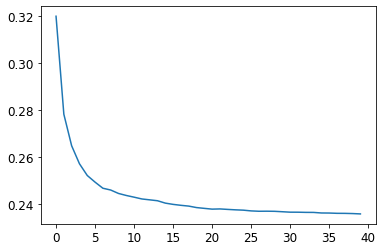

In [44]:
# show how the performance increases as we include predictions from more trees 
preds = np.stack([t.predict(valid_xs.values) for t in m.estimators_])
plt.plot([rmse(preds[:i+1].mean(0), valid_y.values) for i in range(len(m.estimators_))]);

### Out-of-bag error 

The out of bag prediction for a data point only uses the trees which did NOT include this datapoint in their data. Using these predictions to calculate the error gives us a "validation" error, in the sense that we're evaluting on unseen data 

In [51]:

rmse(m.oob_prediction_, y)

0.21243214649139508

We see the error is a little better than the error on our actual validation set (~0.23), which was chosen specifically using a different time range. This tells us the structure of the validation data must be somewhat different to the training data (makes sense). 